In [113]:
!pip install catboost

In [114]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import norm, skew #for some statistics
from scipy import stats
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression


In [115]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv("train.csv")
X_test = pd.read_csv("test.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToIncomeRatio           104

In [116]:
df_cleaned = train_df.dropna(how='all').reset_index(drop=True)
train_df = df_cleaned

In [117]:
train_df = train_df[(train_df['RiskScore'] >= -100000) & (train_df['RiskScore'] <= 100000)]

In [118]:
df_cleaned = train_df.dropna()
train_df = df_cleaned

In [119]:
train_df = train_df.drop(columns=['RiskScore'])
train_df.info()
X_test = X_test.drop(columns=['LoanApproved'])

<class 'pandas.core.frame.DataFrame'>
Index: 9787 entries, 0 to 10485
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             9787 non-null   object 
 1   Age                         9787 non-null   float64
 2   AnnualIncome                9787 non-null   float64
 3   CreditScore                 9787 non-null   float64
 4   LoanAmount                  9787 non-null   float64
 5   LoanDuration                9787 non-null   float64
 6   MaritalStatus               9787 non-null   object 
 7   NumberOfDependents          9787 non-null   float64
 8   HomeOwnershipStatus         9787 non-null   object 
 9   MonthlyDebtPayments         9787 non-null   float64
 10  CreditCardUtilizationRate   9787 non-null   float64
 11  NumberOfOpenCreditLines     9787 non-null   float64
 12  NumberOfCreditInquiries     9787 non-null   float64
 13  DebtToIncomeRatio           9787 non-

In [120]:

train_df['ApplicationDate'] = pd.to_datetime(train_df['ApplicationDate'])

train_df['ApplicationDate'] = train_df['ApplicationDate'].apply(lambda ts: ts.year)


X_test['ApplicationDate'] = pd.to_datetime(X_test['ApplicationDate'])


X_test['ApplicationDate'] = X_test['ApplicationDate'].apply(lambda ts: ts.year)


In [121]:




train_df = pd.get_dummies(train_df, columns=['MaritalStatus'], prefix='Mar')
train_df = train_df.drop(columns=['Mar_Widowed'])



train_df = pd.get_dummies(train_df, columns=['EmploymentStatus'], prefix='Emp')
train_df = train_df.drop(columns=['Emp_Unemployed'])




# Тест

X_test = pd.get_dummies(X_test, columns=['MaritalStatus'], prefix='Mar')
X_test = X_test.drop(columns=['Mar_Widowed'])




X_test = pd.get_dummies(X_test, columns=['EmploymentStatus'], prefix='Emp')
X_test = X_test.drop(columns=['Emp_Unemployed'])
train_df







,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,...,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,Mar_Divorced,Mar_Married,Mar_Single,Emp_Employed,Emp_Self-Employed
0,2010,27.0,66829.0,549.0,17290.0,60.0,1.0,Rent,1095.0,0.151985,...,0.257790,0.251465,508.970230,0.288013,0.0,True,False,False,True,False
1,1996,55.0,172147.0,850.0,16110.0,36.0,1.0,Mortgage,211.0,0.175693,...,0.086110,0.093173,514.675859,0.050585,1.0,False,False,False,True,False
2,2015,51.0,300000.0,850.0,38436.0,36.0,0.0,Mortgage,546.0,0.444605,...,0.108436,0.115443,1268.276385,0.072571,1.0,False,True,False,True,False
3,1981,25.0,34683.0,847.0,19186.0,48.0,0.0,Other,153.0,0.188452,...,0.100686,0.112822,498.505187,0.225415,1.0,False,True,False,True,False
4,1995,55.0,300000.0,850.0,30437.0,48.0,2.0,Rent,562.0,0.273431,...,0.110437,0.089037,756.035156,0.052721,1.0,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10481,1984,47.0,88686.0,648.0,5472.0,12.0,2.0,Rent,98.0,0.112650,...,0.156472,0.164928,497.756143,0.080611,1.0,True,False,False,True,False
10482,1980,39.0,300000.0,850.0,7721.0,72.0,5.0,Own,276.0,0.215136,...,0.107721,0.108596,146.407421,0.016896,1.0,True,False,False,True,False
10483,2010,57.0,300000.0,850.0,14756.0,48.0,2.0,Own,620.0,0.477742,...,0.094756,0.106387,378.792448,0.039952,1.0,False,True,False,True,False
10484,2003,28.0,15000.0,300.0,51361.0,96.0,1.0,Own,696.0,0.322554,...,0.446361,0.401087,1793.042130,1.991234,0.0,False,False,True,True,False


In [122]:
train_df['LowDebtToIncomeRatio'] = (train_df['TotalDebtToIncomeRatio'] < 0.4).astype(float)
train_df['SavingsToIncomeRatio'] = train_df['SavingsAccountBalance'] / train_df['AnnualIncome']

X_test['LowDebtToIncomeRatio'] = (X_test['TotalDebtToIncomeRatio'] < 0.4).astype(float)
X_test['SavingsToIncomeRatio'] = X_test['SavingsAccountBalance'] / X_test['AnnualIncome']

In [123]:

# Вычитание значений построчно и создание нового столбца
train_df['new'] = abs(train_df['CheckingAccountBalance'] - train_df['SavingsAccountBalance'])
train_df['neww'] = abs(train_df['MonthlyIncome'] - train_df['MonthlyDebtPayments'])
train_df['LiquidAssets'] = train_df['CheckingAccountBalance'] + train_df['SavingsAccountBalance']
train_df['newww'] = abs(train_df['TotalAssets'] - train_df['TotalLiabilities'])
train_df['LiquidAssetsToLiabilitiesRatio'] = train_df['LiquidAssets'] / train_df['TotalAssets']
train_df['NetWorthToLiabilitiesRatio'] = train_df['NetWorth'] / train_df['TotalLiabilities']
train_df['NetWorthCategory'] = pd.cut(train_df['NetWorth'], bins=[-float('inf'), 0, 50000, float('inf')], labels=[0.0, 1.0, 2.0])
train_df['NetWorthCategory'] = train_df['NetWorthCategory'].astype(float)
train_df['HighRisk'] = train_df['CreditScore'].apply(lambda x: 1 if x < 600 else 0)
train_df['IncomeCategory'] = pd.cut(train_df['AnnualIncome'], bins=[0, 30000, 60000, 90000, float('inf')], labels=[1.0, 2.0, 3.0, 4.0])
income_group_mean = train_df.groupby('IncomeCategory')['CreditScore'].transform('mean')
train_df['CreditScoreDeviationIncome'] = train_df['CreditScore'] - income_group_mean
train_df['DebtToAssetRatio'] = train_df['TotalLiabilities'] / train_df['TotalAssets']
train_df['MonthlyLoanPaymentToIncomeRatio'] = train_df['MonthlyLoanPayment'] / train_df['MonthlyIncome']
train_df['UtilityPaymentsToIncomeRatio'] = train_df['UtilityBillsPaymentHistory'] / train_df['MonthlyIncome']
train_df['EmploymentStability'] = train_df['JobTenure'].apply(lambda x: 1 if x >= 5 else 0)
train_df['CreditScoreCategory'] = pd.cut(train_df['CreditScore'], bins=[0, 300, 550, 722, 850, float('inf')], labels=[1.0, 2.0, 3.0, 4.0, 5.0])
train_df['HighCreditScoreFlag'] = train_df['CreditScore'].apply(lambda x: 1 if x >= 740 else 0)
train_df['DefaultRiskScore'] = train_df['CreditScore'].apply(lambda x: 1 if x < 580 else 0)
train_df['DefaultRiskScoren'] = train_df['CreditScore'].apply(lambda x: 1 if x < 550 else 0)
train_df['WeightedCreditScore'] = train_df['CreditScore'] * train_df['AnnualIncome']
train_df['IncomeToDebtRatio'] = train_df['AnnualIncome'] / train_df['TotalLiabilities']
hours_per_year = 2080
train_df['HourlyIncome'] = train_df['AnnualIncome'] / hours_per_year
train_df['IncomeByAgeGroup'] = train_df.groupby('Age')['AnnualIncome'].transform('mean')
train_df['IncomeToBaseInterestRate'] = train_df['AnnualIncome'] / train_df['BaseInterestRate']
median_loan_amount = train_df['LoanAmount'].median()
train_df['HighLoanAmountFlag'] = (train_df['LoanAmount'] > median_loan_amount).astype(float)




train_df['DebtToIncomeCategory'] = pd.cut(train_df['DebtToIncomeRatio'],
                                            bins=[-float('inf'), 0.2, 0.3, 0.4, 0.499, float('inf')],
                                           labels=[0.0, 1.0, 2.0, 3.0, 4.0])

train_df['SavingsBalanceCategory'] = pd.cut(train_df['SavingsAccountBalance'],
                                             bins=[-float('inf'), 1000, 4000, 8000, float('inf')],
                                             labels=[0.0, 1.0, 2.0, 3.0])


train_df['LoanAmountCategory'] = pd.cut(train_df['LoanAmount'],
                                          bins=[0, 10000, 30000, 50000, 70000, float('inf')],
                                          labels=[0.0, 1.0, 2.0, 3.0, 4.0])



train_df['TotalAssetsCategory'] = pd.cut(train_df['TotalAssets'],
                                           bins=[0, 50000, 150000, 300000, float('inf')],
                                           labels=[0.0, 1.0, 2.0, 3.0])

train_df['CreditHistoryCategory'] = pd.cut(train_df['LengthOfCreditHistory'],
                                             bins=[0, 2, 5, 9, float('inf')],
                                             labels=[0.0, 1.0, 2.0, 3.0])




train_df['CreditCardUtilizationCategory'] = pd.cut(train_df['CreditCardUtilizationRate'],
                                                    bins=[-float('inf'), 0.2, 0.3, 0.4, 0.5, float('inf')],
                                                    labels=[0.0, 1.0, 2.0, 3.0, 4.0])




train_df['PaymentHistoryCategory'] = pd.cut(train_df['PaymentHistory'],
                                             bins=[-1, 14, float('inf')],
                                             labels=[0.0, 1.0])
#1 5 10 15
train_df['LowDebtToIncomeFlag'] = (train_df['DebtToIncomeCategory'] <= 1.0).astype(float)


train_df['InterestRateToIncomeRatio'] = train_df['InterestRate'] / train_df['AnnualIncome']
train_df['InterestRateToIncomeCategory'] = pd.cut(train_df['InterestRateToIncomeRatio'],
                                                 bins=[-float('inf'), 1e-7, 2e-7, 5e-6, 1e-5, float('inf')],
                                                 labels=[0.0, 1.0, 2.0, 3.0, 4.0])


train_df['CheckingBalanceCategory'] = pd.cut(train_df['CheckingAccountBalance'],
                                           bins=[-float('inf'), 19000, 35000, 60000, float('inf')],
                                           labels=[0.0, 1.0, 2.0, 3.0])





# Вычитание значений построчно и создание нового столбца
X_test['new'] = abs(X_test['CheckingAccountBalance'] - X_test['SavingsAccountBalance'])
X_test['neww'] = abs(X_test['MonthlyIncome'] - X_test['MonthlyDebtPayments'])
X_test['LiquidAssets'] = X_test['CheckingAccountBalance'] + X_test['SavingsAccountBalance']
X_test['newww'] = abs(X_test['TotalAssets'] - X_test['TotalLiabilities'])
X_test['LiquidAssetsToLiabilitiesRatio'] = X_test['LiquidAssets'] / X_test['TotalAssets']
X_test['NetWorthToLiabilitiesRatio'] = X_test['NetWorth'] / X_test['TotalLiabilities']
X_test['NetWorthCategory'] = pd.cut(X_test['NetWorth'], bins=[-float('inf'), 0, 50000, float('inf')], labels=[0.0, 1.0, 2.0])
X_test['NetWorthCategory'] = X_test['NetWorthCategory'].astype(float)
X_test['HighRisk'] = X_test['CreditScore'].apply(lambda x: 1 if x < 600 else 0)#
X_test['IncomeCategory'] = pd.cut(X_test['AnnualIncome'], bins=[0, 30000, 60000, 90000, float('inf')], labels=[1.0, 2.0, 3.0, 4.0])
income_group_mean = X_test.groupby('IncomeCategory')['CreditScore'].transform('mean')
X_test['CreditScoreDeviationIncome'] = X_test['CreditScore'] - income_group_mean
X_test['DebtToAssetRatio'] = X_test['TotalLiabilities'] / X_test['TotalAssets']
X_test['MonthlyLoanPaymentToIncomeRatio'] = X_test['MonthlyLoanPayment'] / X_test['MonthlyIncome']
X_test['UtilityPaymentsToIncomeRatio'] = X_test['UtilityBillsPaymentHistory'] / X_test['MonthlyIncome']
X_test['EmploymentStability'] = X_test['JobTenure'].apply(lambda x: 1 if x >= 5 else 0)
X_test['CreditScoreCategory'] = pd.cut(X_test['CreditScore'], bins=[0, 300, 550, 722, 850, float('inf')], labels=[1.0, 2.0, 3.0, 4.0, 5.0])
X_test['HighCreditScoreFlag'] = X_test['CreditScore'].apply(lambda x: 1 if x >= 740 else 0)#
X_test['DefaultRiskScore'] = X_test['CreditScore'].apply(lambda x: 1 if x < 580 else 0)#
X_test['DefaultRiskScoren'] = X_test['CreditScore'].apply(lambda x: 1 if x < 550 else 0)
X_test['WeightedCreditScore'] = X_test['CreditScore'] * X_test['AnnualIncome']
X_test['IncomeToDebtRatio'] = X_test['AnnualIncome'] / X_test['TotalLiabilities']
hours_per_year = 2080
X_test['HourlyIncome'] = X_test['AnnualIncome'] / hours_per_year
X_test['IncomeByAgeGroup'] = X_test.groupby('Age')['AnnualIncome'].transform('mean')
X_test['IncomeToBaseInterestRate'] = X_test['AnnualIncome'] / X_test['BaseInterestRate']
median_loan_amount = X_test['LoanAmount'].median()
X_test['HighLoanAmountFlag'] = (X_test['LoanAmount'] > median_loan_amount).astype(float)



X_test['DebtToIncomeCategory'] = pd.cut(X_test['DebtToIncomeRatio'],
                                           bins=[-float('inf'), 0.2, 0.3, 0.4, 0.499, float('inf')],
                                           labels=[0.0, 1.0, 2.0, 3.0, 4.0])


X_test['SavingsBalanceCategory'] = pd.cut(X_test['SavingsAccountBalance'],
                                             bins=[-float('inf'), 1000, 4000, 8000, float('inf')],
                                             labels=[0.0, 1.0, 2.0, 3.0])

X_test['LoanAmountCategory'] = pd.cut(X_test['LoanAmount'],
                                          bins=[0, 10000, 30000, 50000, 70000, float('inf')],
                                          labels=[0.0, 1.0, 2.0, 3.0, 4.0])


X_test['TotalAssetsCategory'] = pd.cut(X_test['TotalAssets'],
                                           bins=[0, 50000, 150000, 300000, float('inf')],
                                           labels=[0.0, 1.0, 2.0, 3.0])


X_test['CreditHistoryCategory'] = pd.cut(X_test['LengthOfCreditHistory'],
                                             bins=[0, 2, 5, 9, float('inf')],
                                             labels=[0.0, 1.0, 2.0, 3.0])




X_test['CreditCardUtilizationCategory'] = pd.cut(X_test['CreditCardUtilizationRate'],
                                                    bins=[-float('inf'), 0.2, 0.3, 0.4, 0.5, float('inf')],
                                                    labels=[0.0, 1.0, 2.0, 3.0, 4.0])




X_test['PaymentHistoryCategory'] = pd.cut(X_test['PaymentHistory'],
                                             bins=[-1, 14, float('inf')],
                                             labels=[0.0, 1.0])


X_test['LowDebtToIncomeFlag'] = (X_test['DebtToIncomeCategory'] <= 1.0).astype(float)

X_test['InterestRateToIncomeRatio'] = X_test['InterestRate'] / X_test['AnnualIncome']
X_test['InterestRateToIncomeCategory'] = pd.cut(X_test['InterestRateToIncomeRatio'],
                                                 bins=[-float('inf'), 1e-7, 2e-7, 5e-6, 1e-5, float('inf')],
                                                 labels=[0.0, 1.0, 2.0, 3.0, 4.0])

X_test['CheckingBalanceCategory'] = pd.cut(X_test['CheckingAccountBalance'],
                                           bins=[-float('inf'), 19000, 35000, 60000, float('inf')],
                                           labels=[0.0, 1.0, 2.0, 3.0])



<ipython-input-123-19fdc980fa94>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_group_mean = train_df.groupby('IncomeCategory')['CreditScore'].transform('mean')
<ipython-input-123-19fdc980fa94>:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_group_mean = X_test.groupby('IncomeCategory')['CreditScore'].transform('mean')


In [124]:

train_df['LoanPaymentToLoanAmountRatio'] = train_df['MonthlyLoanPayment'] / train_df['LoanAmount']

train_df['LoanPaymentToDebtToIncomeRatio'] = train_df['MonthlyLoanPayment'] / train_df['TotalDebtToIncomeRatio']

train_df['LoanPaymentAsPercentOfNetWorth'] = train_df['MonthlyLoanPayment'] / train_df['NetWorth']

train_df['LoanPaymentToMonthlyDebtRatio'] = train_df['MonthlyLoanPayment'] / train_df['MonthlyDebtPayments']
train_df['LoanPaymentAsPercentOfTotalDebt'] = train_df['MonthlyLoanPayment'] / train_df['TotalLiabilities']




train_df['HighInterestRateFlag'] = (train_df['InterestRate'] > 0.1).astype(float)
train_df['InterestRateToIncomeRatio'] = train_df['InterestRate'] / train_df['AnnualIncome']
train_df['InterestRateToDebtToIncomeRatio'] = train_df['InterestRate'] / train_df['TotalDebtToIncomeRatio']
mean_rate = train_df['InterestRate'].mean()
std_rate = train_df['InterestRate'].std()
train_df['InterestRateFluctuationFlag'] = ((train_df['InterestRate'] > (mean_rate + 2 * std_rate)) |
                                         (train_df['InterestRate'] < (mean_rate - 2 * std_rate))).astype(float)
train_df['InterestRateToCreditCardUtilization'] = train_df['InterestRate'] / (train_df['CreditCardUtilizationRate'] + 1)
train_df['InterestRateForFirstLoanFlag'] = ((train_df['PreviousLoanDefaults'] == 0) &
                                          (train_df['InterestRate'] > 0.10)).astype(float)





X_test['LoanPaymentToLoanAmountRatio'] = X_test['MonthlyLoanPayment'] / X_test['LoanAmount']
X_test['LoanPaymentToDebtToIncomeRatio'] = X_test['MonthlyLoanPayment'] / X_test['TotalDebtToIncomeRatio']

X_test['LoanPaymentAsPercentOfNetWorth'] = X_test['MonthlyLoanPayment'] / X_test['NetWorth']

X_test['LoanPaymentToMonthlyDebtRatio'] = X_test['MonthlyLoanPayment'] / X_test['MonthlyDebtPayments']
X_test['LoanPaymentAsPercentOfTotalDebt'] = X_test['MonthlyLoanPayment'] / X_test['TotalLiabilities']




X_test['HighInterestRateFlag'] = (X_test['InterestRate'] > 0.1).astype(float)
X_test['InterestRateToIncomeRatio'] = X_test['InterestRate'] / X_test['AnnualIncome']
X_test['InterestRateToDebtToIncomeRatio'] = X_test['InterestRate'] / X_test['TotalDebtToIncomeRatio']
mean_rate = X_test['InterestRate'].mean()
std_rate = X_test['InterestRate'].std()
X_test['InterestRateFluctuationFlag'] = ((X_test['InterestRate'] > (mean_rate + 2 * std_rate)) |
                                         (X_test['InterestRate'] < (mean_rate - 2 * std_rate))).astype(float)
X_test['InterestRateToCreditCardUtilization'] = X_test['InterestRate'] / (X_test['CreditCardUtilizationRate'] + 1)
X_test['InterestRateForFirstLoanFlag'] = ((X_test['PreviousLoanDefaults'] == 0) &
                                          (X_test['InterestRate'] > 0.10)).astype(float)


In [125]:
train_df['LowIncomeRisk'] = train_df['AnnualIncome'].apply(lambda x: 1 if x < 36000 else 0)
train_df['LongLoanDurationRisk'] = train_df['LoanDuration'].apply(lambda x: 1 if x > 35 else 0)
train_df['MultipleCreditInquiriesRisk'] = train_df['NumberOfCreditInquiries'].apply(lambda x: 1 if x > 4 else 0)
train_df['LowAssetsRisk'] = train_df['TotalAssets'].apply(lambda x: 1 if x < 5000 else 0)
train_df['ShortLoanDurationRisk'] = train_df['LoanDuration'].apply(lambda x: 1 if x < 18 else 0)
train_df['ManyOpenCreditLinesRisk'] = train_df['NumberOfOpenCreditLines'].apply(lambda x: 1 if x > 9 else 0)
train_df['LateUtilityPaymentPenalty'] = 1 - train_df['UtilityBillsPaymentHistory']

train_df['LowCreditAndPoorUtilityPayment'] = train_df.apply(lambda x: 1 if (x['CreditScore'] < 600) and (x['UtilityBillsPaymentHistory'] < 0.3) else 0, axis=1)




X_test['LowIncomeRisk'] = X_test['AnnualIncome'].apply(lambda x: 1 if x < 36000 else 0)
X_test['LongLoanDurationRisk'] = X_test['LoanDuration'].apply(lambda x: 1 if x > 35 else 0)
X_test['MultipleCreditInquiriesRisk'] = X_test['NumberOfCreditInquiries'].apply(lambda x: 1 if x > 4 else 0)
X_test['LowAssetsRisk'] = X_test['TotalAssets'].apply(lambda x: 1 if x < 5000 else 0)
X_test['ShortLoanDurationRisk'] = X_test['LoanDuration'].apply(lambda x: 1 if x < 18 else 0)
X_test['ManyOpenCreditLinesRisk'] = X_test['NumberOfOpenCreditLines'].apply(lambda x: 1 if x > 9 else 0)
X_test['LateUtilityPaymentPenalty'] = 1 - X_test['UtilityBillsPaymentHistory']

X_test['LowCreditAndPoorUtilityPayment'] = X_test.apply(lambda x: 1 if (x['CreditScore'] < 600) and (x['UtilityBillsPaymentHistory'] < 0.3) else 0, axis=1)





In [126]:
train_df['CheckingAccountBalanceСat'] = pd.cut(train_df['CheckingAccountBalance'],
                                             bins=[-float('inf'), 800, 2500, 4900, float('inf')],
                                             labels=[0.0, 1.0, 2.0, 3.0])

train_df['CreditUtilizationCategory'] = pd.cut(train_df['CreditCardUtilizationRate'],
                                             bins=[-float('inf'), 0.2, 0.4, 0.6, float('inf')],
                                             labels=[0.0, 1.0, 2.0, 3.0])

train_df['HighCreditUtilizationFlag'] = train_df['CreditCardUtilizationRate'].apply(lambda x: 1 if x > 0.5 else 0)

train_df['CreditUtilizationDebtInteraction'] = train_df['CreditCardUtilizationRate'] * train_df['DebtToIncomeRatio']

train_df['ExtremeDebtToIncomeFlag'] =  train_df['DebtToIncomeRatio'].apply(lambda x: 1 if x < 0.4 or x > 0.6 else 0)



train_df['DebtToCreditLinesRatio'] = train_df['DebtToIncomeRatio'] / train_df['NumberOfOpenCreditLines']
train_df['DebtToCreditLinesRatio'] = train_df['DebtToCreditLinesRatio'].replace([np.inf, -np.inf], np.nan)
train_df['DebtToCreditLinesRatio'] = train_df['DebtToCreditLinesRatio'].fillna(0)
train_df['DebtToCreditLinesRatio'] = np.clip(train_df['DebtToCreditLinesRatio'], -1e6, 1e6)

train_df['ProgressiveDebtToIncomeFlag'] = (train_df['DebtToIncomeRatio'] > train_df['DebtToIncomeRatio'].shift(1)).astype(float)

train_df['DebtToIncomeCreditInquiriesInteraction'] = train_df['DebtToIncomeRatio'] * train_df['NumberOfCreditInquiries']

train_df['HighDebtLowSavingsFlag'] = ((train_df['DebtToIncomeRatio'] > 0.4) & (train_df['SavingsAccountBalance'] < 485)).astype(float)


train_df['HighInterestLowCreditScoreFlag'] = ((train_df['InterestRate'] > 0.1) & (train_df['CreditScore'] < 650)).astype(float)

train_df['HighInterestLowIncomeFlag'] = ((train_df['InterestRate'] > 0.1) & (train_df['MonthlyIncome'] < 2000)).astype(float)

train_df['HighInterestHighLiabilitiesFlag'] = ((train_df['InterestRate'] > 0.1) & (train_df['TotalLiabilities'] > 30000)).astype(float)

train_df['HighCreditUtilizationLowCreditScoreFlag'] = ((train_df['CreditCardUtilizationRate'] > 0.6) & (train_df['CreditScore'] < 650)).astype(float)

train_df['HighInterestLowAssetsFlag'] = ((train_df['InterestRate'] > 0.1) & (train_df['TotalAssets'] < 15000)).astype(float)

train_df['LowIncomeHighLoanAmountFlag'] = ((train_df['MonthlyIncome'] < 2500) & (train_df['LoanAmount'] > 40000)).astype(float)

train_df['LowCreditScoreHighLoanAmountFlag'] = ((train_df['CreditScore'] < 650) & (train_df['LoanAmount'] > 19900)).astype(float)

train_df['LongLoanDurationLowIncomeFlag'] = ((train_df['LoanDuration'] > 50) & (train_df['MonthlyIncome'] < 1500)).astype(float)

train_df['HighCreditUtilizationLowIncomeFlag'] = ((train_df['CreditCardUtilizationRate'] > 0.7) & (train_df['MonthlyIncome'] < 1500)).astype(float)

train_df['LowCreditScoreHighDebtFlag'] = ((train_df['CreditScore'] < 680) & (train_df['DebtToIncomeRatio'] > 0.15)).astype(float)

train_df['LowCreditScoreHighCreditUtilizationFlag'] = ((train_df['CreditScore'] < 600) & (train_df['CreditCardUtilizationRate'] > 0.15)).astype(float)

train_df['LowCreditScoreHighMonthlyDebtFlag'] = ((train_df['CreditScore'] < 600) & (train_df['MonthlyDebtPayments'] > 1500)).astype(float)

train_df['YoungAgeHighLoanAmountFlag'] = ((train_df['Age'] < 25) & (train_df['LoanAmount'] > 60000)).astype(float)

train_df['HighCreditScoreLowJobTenureFlag'] = ((train_df['CreditScore'] > 700) & (train_df['JobTenure'] < 2)).astype(float)

train_df['LowIncomeHighInterestRateFlag'] = ((train_df['MonthlyIncome'] < 4200) & (train_df['InterestRate'] > 0.1)).astype(float)







X_test['CheckingAccountBalanceСat'] = pd.cut(X_test['CheckingAccountBalance'],
                                             bins=[-float('inf'), 800, 2500, 4900, float('inf')],
                                             labels=[0.0, 1.0, 2.0, 3.0])

X_test['CreditUtilizationCategory'] = pd.cut(X_test['CreditCardUtilizationRate'],
                                             bins=[-float('inf'), 0.2, 0.4, 0.6, float('inf')],
                                             labels=[0.0, 1.0, 2.0, 3.0])

X_test['HighCreditUtilizationFlag'] = X_test['CreditCardUtilizationRate'].apply(lambda x: 1 if x > 0.55 else 0)

X_test['CreditUtilizationDebtInteraction'] = X_test['CreditCardUtilizationRate'] * X_test['DebtToIncomeRatio']

X_test['ExtremeDebtToIncomeFlag'] = X_test['DebtToIncomeRatio'].apply(lambda x: 1 if x < 0.4 or x > 0.6 else 0)


X_test['DebtToCreditLinesRatio'] = X_test['DebtToIncomeRatio'] / X_test['NumberOfOpenCreditLines']
X_test['DebtToCreditLinesRatio'] = X_test['DebtToCreditLinesRatio'].replace([np.inf, -np.inf], np.nan)
X_test['DebtToCreditLinesRatio'] = X_test['DebtToCreditLinesRatio'].fillna(0)
X_test['DebtToCreditLinesRatio'] = np.clip(X_test['DebtToCreditLinesRatio'], -1e6, 1e6)

X_test['ProgressiveDebtToIncomeFlag'] = (X_test['DebtToIncomeRatio'] > X_test['DebtToIncomeRatio'].shift(1)).astype(float)

X_test['DebtToIncomeCreditInquiriesInteraction'] = X_test['DebtToIncomeRatio'] * X_test['NumberOfCreditInquiries']



X_test['HighDebtLowSavingsFlag'] = ((X_test['DebtToIncomeRatio'] > 0.4) & (X_test['SavingsAccountBalance'] < 485)).astype(float)


X_test['HighInterestLowCreditScoreFlag'] = ((X_test['InterestRate'] > 0.1) & (X_test['CreditScore'] < 650)).astype(float)

X_test['HighInterestLowIncomeFlag'] = ((X_test['InterestRate'] > 0.1) & (X_test['MonthlyIncome'] < 2000)).astype(float)

X_test['HighInterestHighLiabilitiesFlag'] = ((X_test['InterestRate'] > 0.1) & (X_test['TotalLiabilities'] > 30000)).astype(float)

X_test['HighCreditUtilizationLowCreditScoreFlag'] = ((X_test['CreditCardUtilizationRate'] > 0.6) & (X_test['CreditScore'] < 650)).astype(float)

X_test['HighInterestLowAssetsFlag'] = ((X_test['InterestRate'] > 0.1) & (X_test['TotalAssets'] < 15000)).astype(float)

X_test['LowIncomeHighLoanAmountFlag'] = ((X_test['MonthlyIncome'] < 2500) & (X_test['LoanAmount'] > 40000)).astype(float)


X_test['LowCreditScoreHighLoanAmountFlag'] = ((X_test['CreditScore'] < 650) & (X_test['LoanAmount'] > 19900)).astype(float)

X_test['LongLoanDurationLowIncomeFlag'] = ((X_test['LoanDuration'] > 50) & (X_test['MonthlyIncome'] < 1500)).astype(float)

X_test['HighCreditUtilizationLowIncomeFlag'] = ((X_test['CreditCardUtilizationRate'] > 0.7) & (X_test['MonthlyIncome'] < 1500)).astype(float)

X_test['LowCreditScoreHighDebtFlag'] = ((X_test['CreditScore'] < 680) & (X_test['DebtToIncomeRatio'] > 0.15)).astype(float)

X_test['LowCreditScoreHighCreditUtilizationFlag'] = ((X_test['CreditScore'] < 600) & (X_test['CreditCardUtilizationRate'] > 0.15)).astype(float)

X_test['LowCreditScoreHighMonthlyDebtFlag'] = ((X_test['CreditScore'] < 600) & (X_test['MonthlyDebtPayments'] > 1500)).astype(float)

X_test['YoungAgeHighLoanAmountFlag'] = ((X_test['Age'] < 25) & (X_test['LoanAmount'] > 60000)).astype(float)

X_test['HighCreditScoreLowJobTenureFlag'] = ((X_test['CreditScore'] > 700) & (X_test['JobTenure'] < 2)).astype(float)

X_test['LowIncomeHighInterestRateFlag'] = ((X_test['MonthlyIncome'] < 4200) & (X_test['InterestRate'] > 0.1)).astype(float)


In [127]:
train_df = train_df.reset_index(drop=True)


train_df = train_df.select_dtypes(exclude=['object'])
X_test = X_test.select_dtypes(exclude=['object'])

y_bobr = train_df['LoanApproved']
X_bobr = train_df.drop(columns=['LoanApproved'])

In [128]:
#4.деление на тренеровочную и валидациооную
X_train, X_valid, y_train, y_valid = train_test_split(
    X_bobr, y_bobr, test_size=0.2, random_state=0)

X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)

In [129]:

from sklearn.preprocessing import PolynomialFeatures


#train
features_to_transform = X_train[['CreditScore']]
poly = PolynomialFeatures(degree=52, include_bias=False)#10 11 12 13 14 не апроверял
poly_features = poly.fit_transform(features_to_transform)
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(features_to_transform.columns))
X_train = pd.concat([X_train, poly_features_df], axis=1)
#X_train = X_train.drop(columns=['CreditScore^2', 'CreditScore^3'])

#valid
features_to_transform = X_valid[['CreditScore']]
#poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.transform(features_to_transform)
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(features_to_transform.columns))
X_valid = pd.concat([X_valid, poly_features_df], axis=1)
#X_valid = X_valid.drop(columns=['CreditScore^2', 'CreditScore^3'])
#test
features_to_transform = X_test[['CreditScore']]
#poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.transform(features_to_transform)
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(features_to_transform.columns))
X_test = pd.concat([X_test, poly_features_df], axis=1)
#X_test = X_test.drop(columns=['CreditScore^2', 'CreditScore^3'])



#train
features_to_transform = X_train[['MonthlyIncome']]
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(features_to_transform)
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(features_to_transform.columns))
X_train = pd.concat([X_train, poly_features_df], axis=1)
#valid
features_to_transform = X_valid[['MonthlyIncome']]
#poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.transform(features_to_transform)
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(features_to_transform.columns))
X_valid = pd.concat([X_valid, poly_features_df], axis=1)
#test
features_to_transform = X_test[['MonthlyIncome']]
#poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.transform(features_to_transform)
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(features_to_transform.columns))
X_test = pd.concat([X_test, poly_features_df], axis=1)





# Удаление дубликатов столбцов
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_valid = X_valid.loc[:, ~X_valid.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

In [130]:





name_c3 = 'TotalAssets'
name_cc3 = 'TotalAssetsnew'
X_train[name_cc3] = (X_train[name_c3] + 1) ** (1/12) # +1, чтобы избежать логарифма от 0 # plus one
X_valid[name_cc3] = (X_valid[name_c3] + 1) ** (1/12)
X_test[name_cc3] = (X_test[name_c3] + 1) ** (1/12)
X_train = X_train.drop(columns=[name_c3])
X_valid = X_valid.drop(columns=[name_c3])
X_test = X_test.drop(columns=[name_c3])



name_c7 = 'TotalLiabilities'
name_cc7 = 'TotalLiabilitiesnew'
X_train[name_cc7] = np.log(X_train[name_c7] + 1)  # +1, чтобы избежать логарифма от 0 # корень не работает
X_valid[name_cc7] = np.log(X_valid[name_c7] + 1)
X_test[name_cc7] = np.log(X_test[name_c7] + 1)
X_train = X_train.drop(columns=[name_c7])
X_valid = X_valid.drop(columns=[name_c7])
X_test = X_test.drop(columns=[name_c7])






name_c8 = 'NetWorth'
name_cc8 = 'NetWorthnew'
X_train[name_cc8] = (X_train[name_c8] + 1) ** (1/6) # +1, чтобы избежать логарифма от 0 6
X_valid[name_cc8] = (X_valid[name_c8] + 1) ** (1/6)
X_test[name_cc8] = (X_test[name_c8] + 1) ** (1/6)
X_train = X_train.drop(columns=[name_c8])
X_valid = X_valid.drop(columns=[name_c8])
X_test = X_test.drop(columns=[name_c8])




name_c5 = 'MonthlyLoanPayment'
name_cc5 = 'MonthlyLoanPaymentnew'
X_train[name_cc5] = np.log(X_train[name_c5] + 1)  # +1, чтобы избежать логарифма от 0 # корень не работает
X_valid[name_cc5] = np.log(X_valid[name_c5] + 1)
X_test[name_cc5] = np.log(X_test[name_c5] + 1)
X_train = X_train.drop(columns=[name_c5])
X_valid = X_valid.drop(columns=[name_c5])
X_test = X_test.drop(columns=[name_c5])





name_c6 = 'TotalDebtToIncomeRatio'
name_cc6 = 'TotalDebtToIncomeRationew'
X_train[name_cc6] = np.sqrt(X_train[name_c6] + 1)  # +1, чтобы избежать логарифма от 0
X_valid[name_cc6] = np.sqrt(X_valid[name_c6] + 1)
X_test[name_cc6] = np.sqrt(X_test[name_c6] + 1)
X_train = X_train.drop(columns=[name_c6])
X_valid = X_valid.drop(columns=[name_c6])
X_test = X_test.drop(columns=[name_c6])





name_c1 = 'LoanAmount'
name_cc1 = 'LoanAmountnew'
X_train[name_cc1] = (X_train[name_c1]) ** (1/3) # +1, чтобы избежать логарифма от 0 ## 1/3 хорошо, a 1/6 плохо
X_valid[name_cc1] = (X_valid[name_c1]) ** (1/3)
X_test[name_cc1] = (X_test[name_c1]) ** (1/3)
X_train = X_train.drop(columns=[name_c1])
X_valid = X_valid.drop(columns=[name_c1])
X_test = X_test.drop(columns=[name_c1])




name_c2 = 'AnnualIncome'
name_cc2 = 'AnnualIncomenew'
X_train[name_cc2] = (X_train[name_c2]) ** (1/6) # +1 6
X_valid[name_cc2] = (X_valid[name_c2]) ** (1/6) # плюс один не проверял
X_test[name_cc2] = (X_test[name_c2]) ** (1/6)
X_train = X_train.drop(columns=[name_c2])
X_valid = X_valid.drop(columns=[name_c2])
X_test = X_test.drop(columns=[name_c2])


name_c4 = 'Experience'
name_cc4 = 'Experiencenew'
X_train[name_cc4] = (X_train[name_c4]) ** (1/10) # +1, чтобы избежать логарифма от 0 ## степень можно уменьшать на копейки ещё
X_valid[name_cc4] = (X_valid[name_c4]) ** (1/10) # плюс один не работает
X_test[name_cc4] = (X_test[name_c4]) ** (1/10)
X_train = X_train.drop(columns=[name_c4])
X_valid = X_valid.drop(columns=[name_c4])
X_test = X_test.drop(columns=[name_c4])





name_c11 = 'BaseInterestRate'
name_cc11 = 'BaseInterestRatenew'
X_train[name_cc11] = np.sqrt(X_train[name_c11])  # +1, чтобы избежать логарифма от 0 # плюс один не проверял
X_valid[name_cc11] = np.sqrt(X_valid[name_c11])
X_test[name_cc11] = np.sqrt(X_test[name_c11])
X_train = X_train.drop(columns=[name_c11])
X_valid = X_valid.drop(columns=[name_c11])
X_test = X_test.drop(columns=[name_c11])


name_c12 = 'InterestRate'
name_cc12 = 'InterestRatenew'
X_train[name_cc12] = np.log(X_train[name_c12] + 1)  # +1, чтобы избежать логарифма от 0 # корень не работает
X_valid[name_cc12] = np.log(X_valid[name_c12] + 1) # корень вроде не работал
X_test[name_cc12] = np.log(X_test[name_c12] + 1)
X_train = X_train.drop(columns=[name_c12])
X_valid = X_valid.drop(columns=[name_c12])
X_test = X_test.drop(columns=[name_c12])

name_c13 = 'LiquidAssets'
name_cc13 = 'LiquidAssetsnew'
X_train[name_cc13] = np.log(X_train[name_c13] + 1)  # +1, чтобы избежать логарифма от 0 # корень не работает
X_valid[name_cc13] = np.log(X_valid[name_c13] + 1) # корень вроде не работал
X_test[name_cc13] = np.log(X_test[name_c13] + 1)
X_train = X_train.drop(columns=[name_c13])
X_valid = X_valid.drop(columns=[name_c13])
X_test = X_test.drop(columns=[name_c13])


name_c14 = 'NetWorthToLiabilitiesRatio'
name_cc14 = 'NetWorthToLiabilitiesRationew'
X_train[name_cc14] = (X_train[name_c14]) ** (1/80)  # +1 можно увеличивать
X_valid[name_cc14] = (X_valid[name_c14]) ** (1/80)# корень вроде не работал
X_test[name_cc14] = (X_test[name_c14]) ** (1/80)
X_train = X_train.drop(columns=[name_c14])
X_valid = X_valid.drop(columns=[name_c14])
X_test = X_test.drop(columns=[name_c14])

name_c15 = 'DebtToAssetRatio'
name_cc15 = 'DebtToAssetRationew'
X_train[name_cc15] = (X_train[name_c15]) ** (1/6)  # +1 можно увеличивать
X_valid[name_cc15] = (X_valid[name_c15]) ** (1/6)# корень вроде не работал
X_test[name_cc15] = (X_test[name_c15]) ** (1/6)
X_train = X_train.drop(columns=[name_c15])
X_valid = X_valid.drop(columns=[name_c15])
X_test = X_test.drop(columns=[name_c15])



name_c16 = 'MonthlyLoanPaymentToIncomeRatio'
name_cc16 = 'MonthlyLoanPaymentToIncomeRationew'
X_train[name_cc16] = (X_train[name_c16]) ** (1/20)  # +1 можно увеличивать#можно ещё увеличить
X_valid[name_cc16] = (X_valid[name_c16]) ** (1/20)# корень вроде не работал
X_test[name_cc16] = (X_test[name_c16]) ** (1/20)
X_train = X_train.drop(columns=[name_c16])
X_valid = X_valid.drop(columns=[name_c16])
X_test = X_test.drop(columns=[name_c16])

name_c17 = 'WeightedCreditScore'
name_cc17 = 'WeightedCreditScorenew'
X_train[name_cc17] = (X_train[name_c17]) ** (1/7)  # +1 можно увеличивать#можно ещё увеличить 7 можно побольше
X_valid[name_cc17] = (X_valid[name_c17]) ** (1/7)# корень вроде не работал
X_test[name_cc17] = (X_test[name_c17]) ** (1/7)
X_train = X_train.drop(columns=[name_c17])
X_valid = X_valid.drop(columns=[name_c17])
X_test = X_test.drop(columns=[name_c17])


name_c18 = 'IncomeToDebtRatio'
name_cc18 = 'IncomeToDebtRationew'
X_train[name_cc18] = (X_train[name_c18]) ** (1/2)  # +1 можно увеличивать#м
X_valid[name_cc18] = (X_valid[name_c18]) ** (1/2)# корень вроде не работал
X_test[name_cc18] = (X_test[name_c18]) ** (1/2)
X_train = X_train.drop(columns=[name_c18])
X_valid = X_valid.drop(columns=[name_c18])
X_test = X_test.drop(columns=[name_c18])




name_c23 = 'SavingsToIncomeRatio'
name_cc23 = 'SavingsToIncomeRationew'
X_train[name_cc23] = (X_train[name_c23]) ** (1/2)  # +1 можно
X_valid[name_cc23] = (X_valid[name_c23]) ** (1/2)# корень вроде не работал
X_test[name_cc23] = (X_test[name_c23]) ** (1/2)
X_train = X_train.drop(columns=[name_c23])
X_valid = X_valid.drop(columns=[name_c23])
X_test = X_test.drop(columns=[name_c23])


name_c24 = 'InterestRateToCreditCardUtilization'
name_cc24 = 'InterestRateToCreditCardUtilizationnew'
X_train[name_cc24] = (X_train[name_c24]) ** (1/2)  # +1 можно
X_valid[name_cc24] = (X_valid[name_c24]) ** (1/2)# корень вроде не работал
X_test[name_cc24] = (X_test[name_c24]) ** (1/2)
X_train = X_train.drop(columns=[name_c24])
X_valid = X_valid.drop(columns=[name_c24])
X_test = X_test.drop(columns=[name_c24])



name_c25 = 'InterestRateToDebtToIncomeRatio'
name_cc25 = 'InterestRateToDebtToIncomeRationew'
X_train[name_cc25] = (X_train[name_c25]) ** (1/2)  # +1 можно
X_valid[name_cc25] = (X_valid[name_c25]) ** (1/2)# корень вроде не работал
X_test[name_cc25] = (X_test[name_c25]) ** (1/2)
X_train = X_train.drop(columns=[name_c25])
X_valid = X_valid.drop(columns=[name_c25])
X_test = X_test.drop(columns=[name_c25])

name_c26 = 'CreditScore^2'
name_cc26 = 'CreditScore^2new'
X_train[name_cc26] = (X_train[name_c26]) ** (1/160)  # +1 можно было 160 можно больше
X_valid[name_cc26] = (X_valid[name_c26]) ** (1/160)# корень вроде не работал
X_test[name_cc26] = (X_test[name_c26]) ** (1/160)
X_train = X_train.drop(columns=[name_c26])
X_valid = X_valid.drop(columns=[name_c26])
X_test = X_test.drop(columns=[name_c26])

name_c27 = 'CreditScore^3'
name_cc27 = 'CreditScore^3new'
X_train[name_cc27] = (X_train[name_c27]) ** (1/8)  # попробовать ещё
X_valid[name_cc27] = (X_valid[name_c27]) ** (1/8)# корень вроде не работал
X_test[name_cc27] = (X_test[name_c27]) ** (1/8)
X_train = X_train.drop(columns=[name_c27])
X_valid = X_valid.drop(columns=[name_c27])
X_test = X_test.drop(columns=[name_c27])
#
name_c28 = 'CreditScore^5'
name_cc28 = 'CreditScore^5new'
X_train[name_cc28] = (X_train[name_c28]) ** (1/4)  # попробовать ещё
X_valid[name_cc28] = (X_valid[name_c28]) ** (1/4)# корень вроде не работал
X_test[name_cc28] = (X_test[name_c28]) ** (1/4)
X_train = X_train.drop(columns=[name_c28])
X_valid = X_valid.drop(columns=[name_c28])
X_test = X_test.drop(columns=[name_c28])

name_c29 = 'CreditUtilizationDebtInteraction'
name_cc29 = 'CreditUtilizationDebtInteractionnew'
X_train[name_cc29] = (X_train[name_c29]) ** (1/3)  # попробовать ещё
X_valid[name_cc29] = (X_valid[name_c29]) ** (1/3)# корень вроде не работал
X_test[name_cc29] = (X_test[name_c29]) ** (1/3)
X_train = X_train.drop(columns=[name_c29])
X_valid = X_valid.drop(columns=[name_c29])
X_test = X_test.drop(columns=[name_c29])

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Columns: 166 entries, ApplicationDate to CreditUtilizationDebtInteractionnew
dtypes: bool(5), category(13), float64(133), int64(15)
memory usage: 9.0 MB


In [131]:
#5.нормализация
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

scaler = StandardScaler()

X_scaled_train = scaler.fit_transform(X_train)
#строго к тестовым принменяем тоже обучение
X_scaled_valid = scaler.transform(X_valid)



Accuracy: 0.89
Precision: 0.89
Recall: 0.90
F1 Score: 0.89


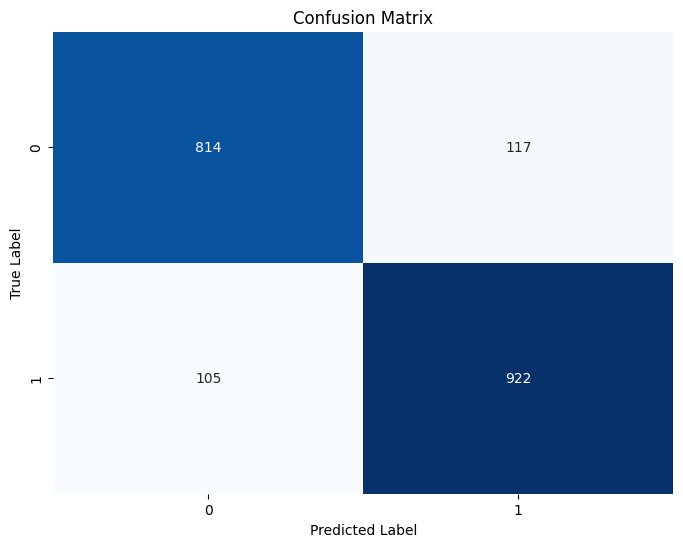

Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1 Score: 0.94


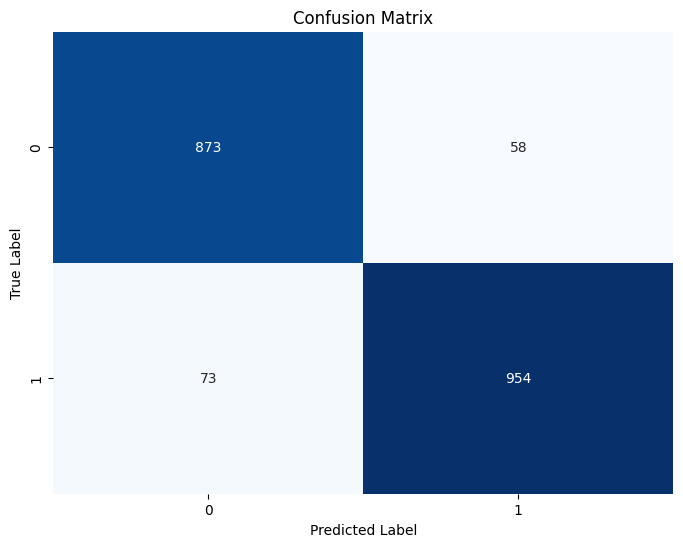

In [132]:


class LinearClassifier:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = np.where(y == 0, -1, 1)
        self.weights = np.zeros(n_features)
        self.bias = 0
        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_pred = 1 if linear_output >= 0 else -1
                if y[idx] != y_pred:
                    self.weights += self.learning_rate * y[idx] * x_i
                    self.bias += self.learning_rate * y[idx]

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        predictions = np.where(linear_output >= 0, 1, 0)
        return predictions




class LogisticClassifier:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for epoch in range(self.epochs):
            for i in range(len(X)):
                linear_output = np.dot(X[i], self.weights) + self.bias
                y_pred = self.sigmoid(linear_output)
                error = y[i] - y_pred

                self.weights += self.learning_rate * error * y_pred * (1 - y_pred) * X[i]
                self.bias += self.learning_rate * error * y_pred * (1 - y_pred)

    def predict(self, X):
        X = np.array(X)
        linear_output = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_output)
        return np.where(y_pred >= 0.5, 1, 0)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

# Линейный классификатор
clf = LinearClassifier(learning_rate=0.01, epochs=1000)
clf.fit(X_scaled_train, y_train)
predictions = clf.predict(X_scaled_valid)

accuracy = accuracy_score(y_valid, predictions)
precision = precision_score(y_valid, predictions)
recall = recall_score(y_valid, predictions)
f1 = f1_score(y_valid, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, predictions)
# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Логистическая регрессия
clf_log = LogisticClassifier(learning_rate=0.01, epochs=1000)
clf_log.fit(X_scaled_train, y_train)
predictions_log = clf_log.predict(X_scaled_valid)

accuracy = accuracy_score(y_valid, predictions_log)
precision = precision_score(y_valid, predictions_log)
recall = recall_score(y_valid, predictions_log)
f1 = f1_score(y_valid, predictions_log)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, predictions_log)
# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [133]:

"""feature_names = X_train.columns

# Преобразование numpy массива в DataFrame
df_scaled_train = pd.DataFrame(X_scaled_train, columns=feature_names)

# Вычисление корреляционной матрицы
correlation_matrix = df_scaled_train.corr()

# Визуализация матрицы корреляции
plt.figure(figsize=(200, 160))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()"""

'feature_names = X_train.columns\n\n# Преобразование numpy массива в DataFrame\ndf_scaled_train = pd.DataFrame(X_scaled_train, columns=feature_names)\n\n# Вычисление корреляционной матрицы\ncorrelation_matrix = df_scaled_train.corr()\n\n# Визуализация матрицы корреляции\nplt.figure(figsize=(200, 160))\nsns.heatmap(correlation_matrix, annot=True, cmap=\'coolwarm\', fmt=".2f", linewidths=0.5)\nplt.title(\'Correlation Matrix Heatmap\')\nplt.show()'

Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1 Score: 0.93


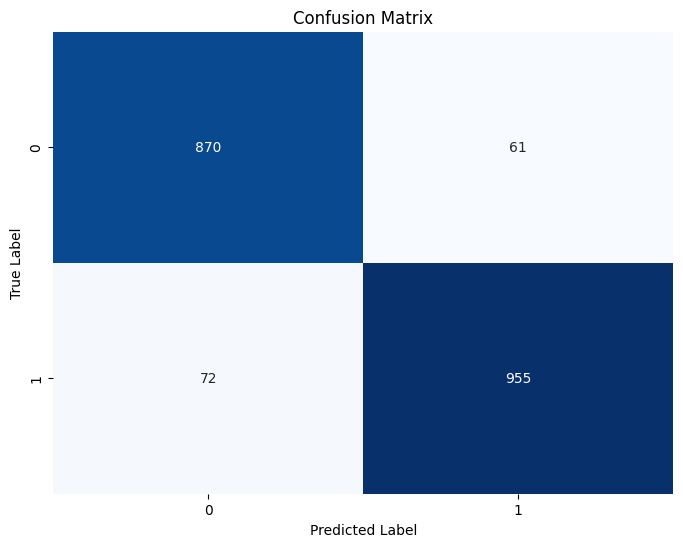

In [134]:
model = LogisticRegression(max_iter=200)
model.fit(X_scaled_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_scaled_valid)

# Оценка модели
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1 Score: 0.93


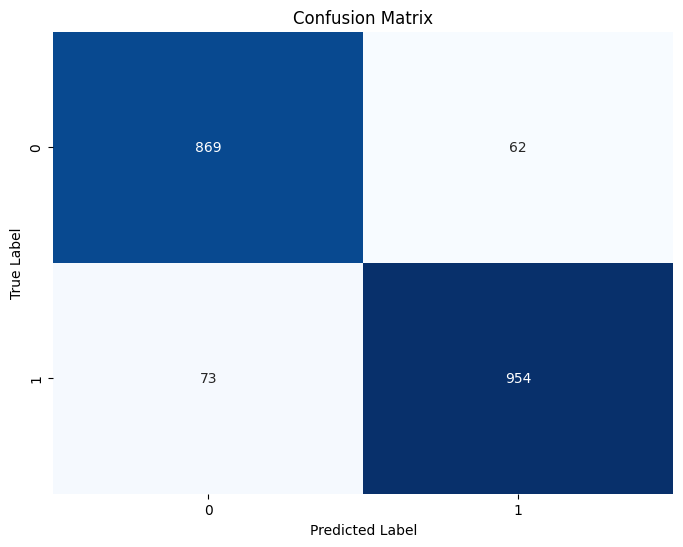

In [135]:
model = SVC(kernel='rbf', C=1.0, random_state=42)
model.fit(X_scaled_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_scaled_valid)

# Оценка модели
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 0.92
Precision: 0.94
Recall: 0.90
F1 Score: 0.92


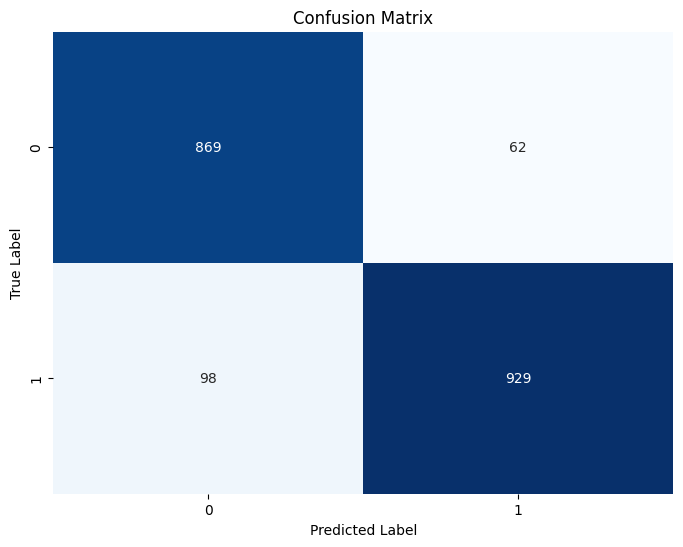

In [136]:
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_scaled_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_scaled_valid)

# Оценка модели
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 0.94
Precision: 0.94
Recall: 0.95
F1 Score: 0.94


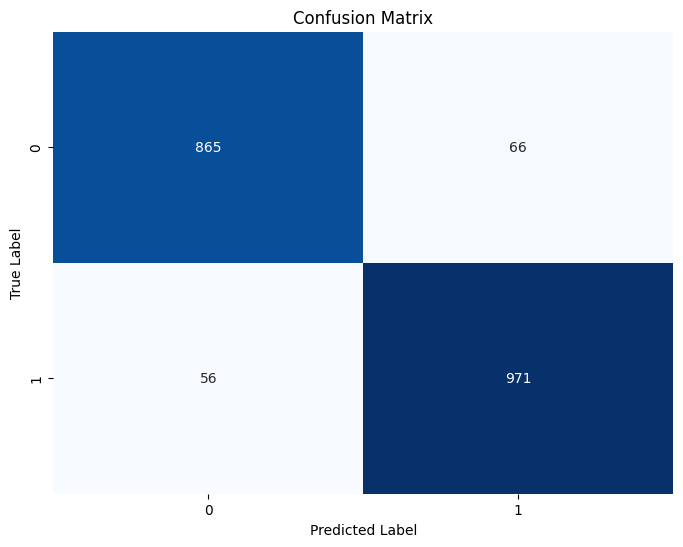

In [137]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_scaled_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_scaled_valid)

# Оценка модели
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


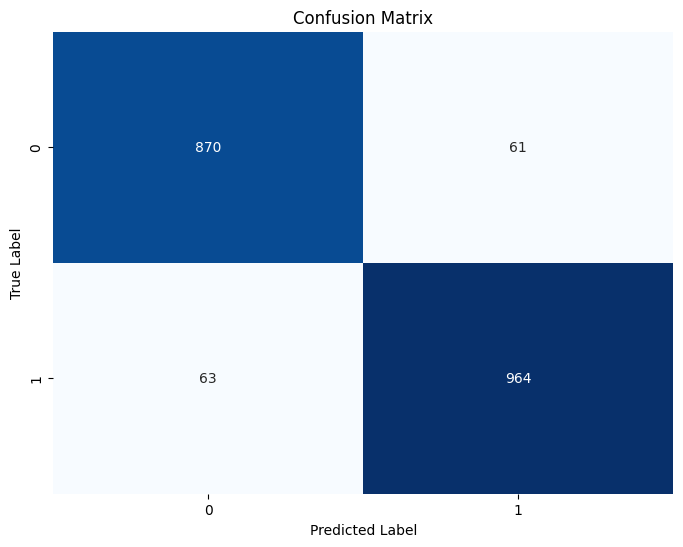

In [138]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_scaled_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_scaled_valid)

# Оценка модели
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3985, number of negative: 3844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22568
[LightGBM] [Info] Number of data points in the train set: 7829, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509005 -> initscore=0.036024
[LightGBM] [Info] Start training from score 0.036024
Accuracy: 0.93
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


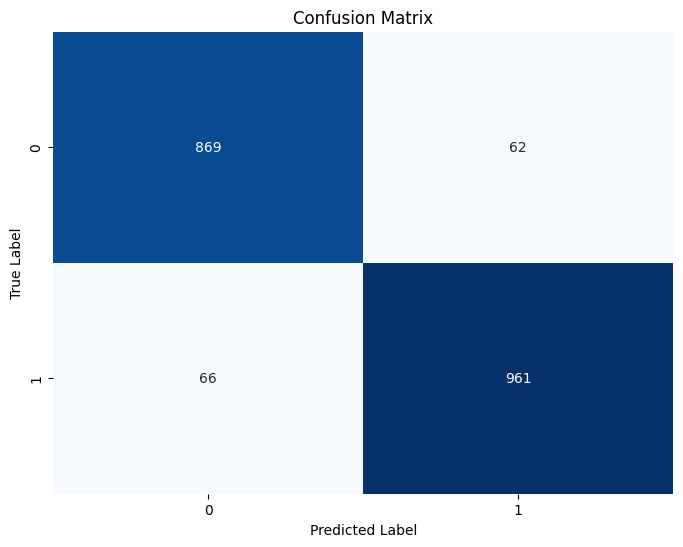

In [139]:
model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
model.fit(X_scaled_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_scaled_valid)

# Оценка модели
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


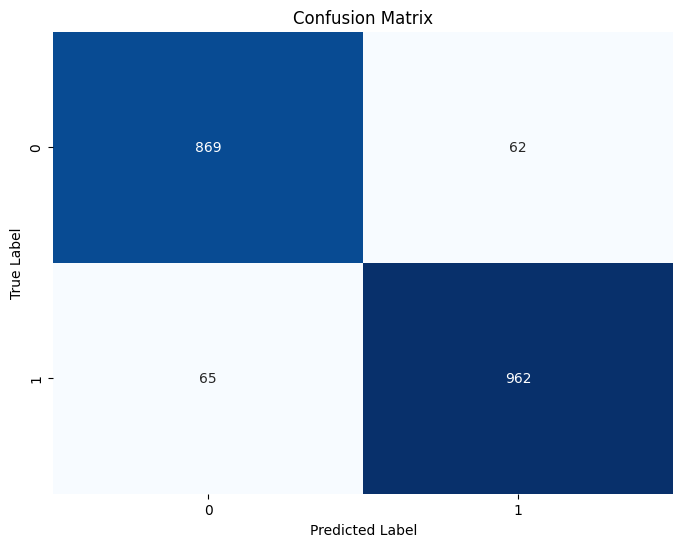

In [140]:
model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_scaled_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_scaled_valid)

# Оценка модели
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


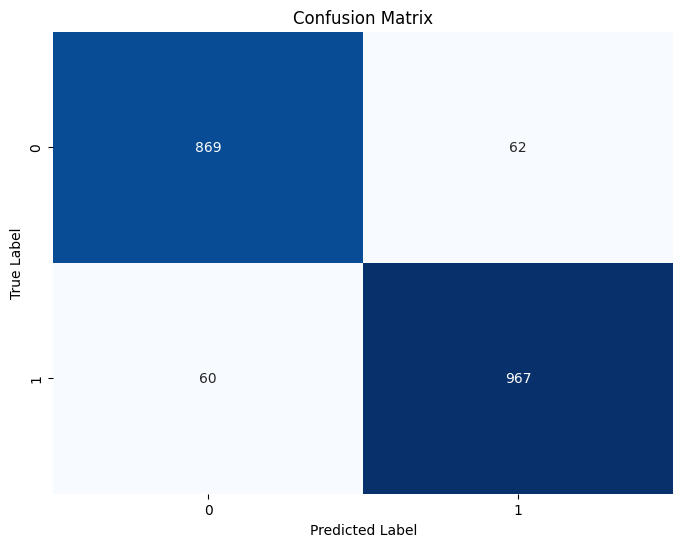

In [141]:
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5, random_state=42, verbose=0)
model.fit(X_scaled_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_scaled_valid)

# Оценка модели
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 0.94
Precision: 0.94
Recall: 0.93
F1 Score: 0.94


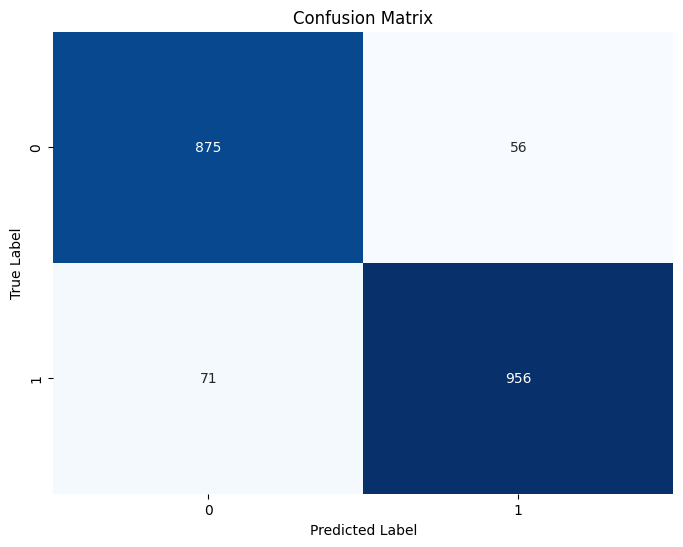

In [142]:
model = HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_scaled_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_scaled_valid)

# Оценка модели
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 0.89
Precision: 0.87
Recall: 0.92
F1 Score: 0.90


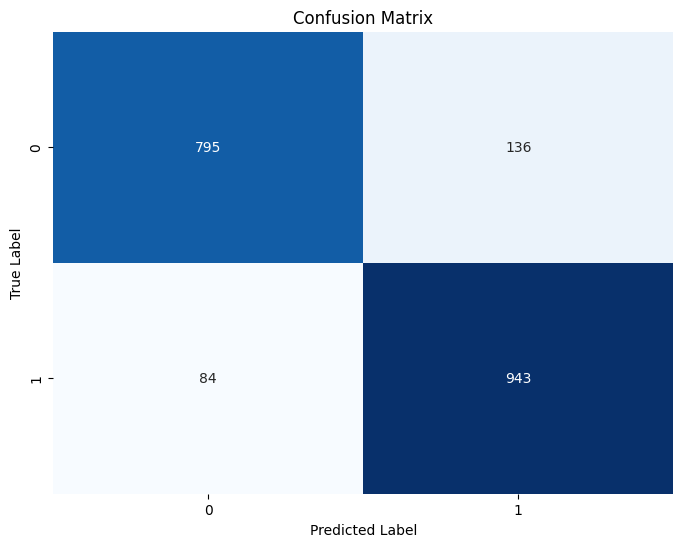

In [143]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_scaled_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_scaled_valid)

# Оценка модели
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 0.89
Precision: 0.88
Recall: 0.92
F1 Score: 0.90


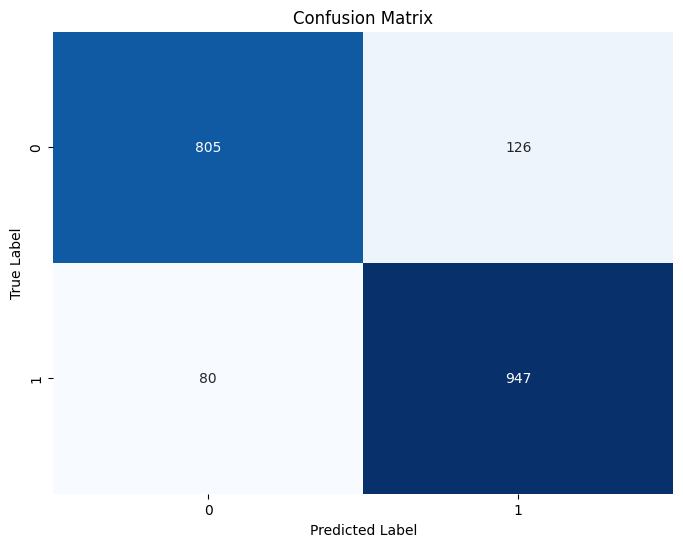

In [144]:
model = ExtraTreesClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_scaled_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_scaled_valid)

# Оценка модели
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 0.92
Precision: 0.93
Recall: 0.92
F1 Score: 0.92


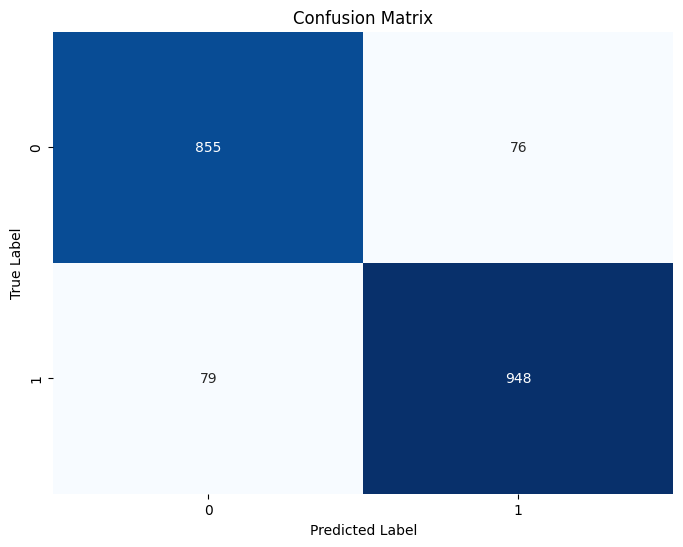

In [145]:
model = RidgeClassifier(alpha=1.0)
model.fit(X_scaled_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_scaled_valid)

# Оценка модели
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1 Score: 0.93


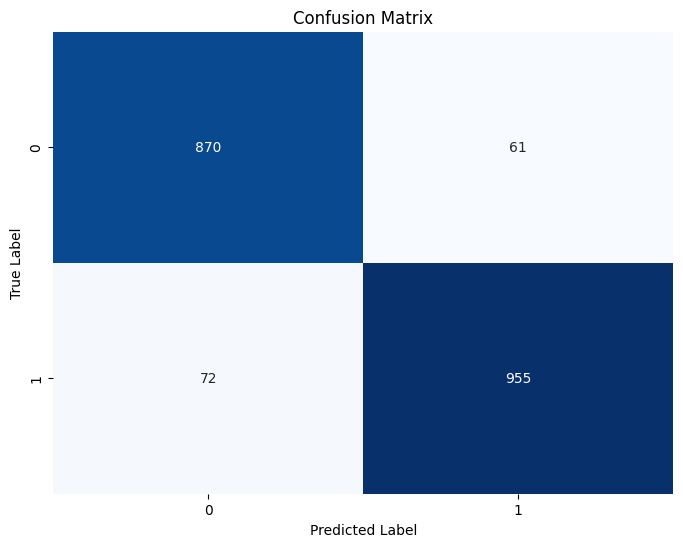

In [146]:
model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
model.fit(X_scaled_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_scaled_valid)

# Оценка модели
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Создание матрицы ошибок
conf_m = confusion_matrix(y_valid, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

На основе анализа различных методов машинного обучения для задачи классификации можно сделать несколько ключевых выводов. Во-первых, для этой задачи использовались такие алгоритмы, как логистическая регрессия, решающее дерево, случайный лес, градиентный бустинг, а также реализации на основе LightGBM, XGBoost и CatBoost. Каждый из этих методов показал разную эффективность в зависимости от характеристик данных и подхода к решению.

Логистическая регрессия показала достаточно хорошие результат. Однако для более сложных данных их производительность могла бы быть ограничена. Алгоритмы, такие как случайный лес и градиентный бустинг, продемонстрировали значительно лучшие результаты, так как они способны выявлять более сложные зависимости между признаками, не ограничиваясь лишь линейными границами. В свою очередь, использование библиотеки LightGBM обеспечило отличную производительность благодаря высокой скорости обучения и эффективности на больших данных.

Наиболее информативной метрикой в этой задаче оказалась accuracy, поскольку она показала, как хорошо модель классифицирует все данные в целом. Однако в случае несбалансированных классов точность может быть не столь полезной. Поэтому важно также отслеживать метрики precision и recall, которые дают более точную оценку работы модели для каждого из классов, особенно в задачах с неравномерным распределением классов.

Кроме того, использование различных подходов и моделей позволяет выбрать оптимальное решение для конкретной задачи. Например, в задачах с большим объемом данных и сложными зависимостями полезно применять методы, такие как XGBoost и CatBoost, которые часто показывают лучшие результаты на реальных данных.

Таким образом, для данной задачи методы градиентного бустинга и ансамбли деревьев решений показали наилучшие результаты по метрикам, в то время как линейные модели были более ограничены в своем применении. Выбор метода зависит от сложности задачи и характеристик данных, а также от необходимости балансировки между точностью и эффективностью модели.